## 4.3 Soft version of Streaming Clustering (Expectation Maximization)
In the previous part, we used Lloyd Hueristics which always off-line error which can not be removed as we get more data. <br>
In this part, we use EM algorithm. In this algorithm, the error will converge to zero as we get more data. <br>

#### 4.3.1 Sample Generator

In [1]:
class SampleGenerator:
    def __init__(self, weights, mu, sigma, d):
        self.weights = weights
        self.mu = mu
        self.sigma=sigma
        self.d = d
    
    def draw_a_sample(self):
        rand = random.uniform(0,1)
        for i in range(len(self.weights)):
            rand -= self.weights[i]
            if (rand <=0):
                return np.random.multivariate_normal(self.mu[:,i], self.sigma * np.identity(self.d), 1).T
    
    def generate_samples(self, sample_size):
        samples = []
        for i in range(sample_size):
            if len(samples) == 0:
                samples = self.draw_a_sample()
            else:
                samples = np.append(samples, self.draw_a_sample(), axis=1)
        return samples

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy import linalg
import random
from sklearn import neighbors
import sklearn.metrics.pairwise
from scipy.sparse import csgraph
import random
import pandas as pd
from numpy import linalg as LA


d = 10
k = 2
n = 2*int(d*d*d*k*k*k*np.log(d*k))
eta = 3 * np.log(n) / n
scaler = 10000
sigma = 100
num_of_samples = int(d*d*d*k*k*k*np.log(d*k))  #N0
w = np.ones(k) / k
while True:
    mu = np.random.rand(1, d) * scaler
    if  2*LA.norm(mu) / sigma > 4:
        break
mu1 = mu.reshape(-1, 1)
mu = np.concatenate([mu1, -mu1], axis=1)

generator = SampleGenerator(w, mu, sigma, d)

In [3]:
N0 = num_of_samples

S = np.zeros((d, d))
k_2 = int (10*k*np.log(k))

B = int(d * np.log(d))
# In this part we use QR algorithm to find k Eigenvectors for each cluster
U = ortho_group.rvs(dim=d)[:, :k]  # Choosing k orthonormal vectors in Rd space
for t in range(N0 - k_2):
    if t % B == B-1:
        Q, R = linalg.qr(np.matmul(S, U))
        # U = np.matmul(R, Q)
        U = Q
        S = np.zeros((d, d))
    # reshaped_sample = samples[:, t].reshape(-1, 1)
    reshaped_sample = generator.draw_a_sample().reshape(-1, 1)
    S = S + np.matmul(reshaped_sample, reshaped_sample.T)
    
X0 = generator.generate_samples(int(k * np.log(k)) * 100)
save_U = U
U = U[:, 0:k]
components = np.matmul(U.T, X0)
adj = neighbors.kneighbors_graph(np.transpose(components), 3)
n_components, labels = csgraph.connected_components(adj)

components = np.matmul(U, components)

components_mean = np.zeros((k, d))
components_by_labels = []
for c in range(k):
    list_of_indices = np.where(labels == c)[0]
    components_mean[c] = np.mean(components[:, list_of_indices], axis=1)
    
print("Components mean:")
pd.DataFrame(components_mean.T)


Components mean:


,0,1
0,7780.678913,-7780.269836
1,7762.025513,-7761.669245
2,7279.064396,-7278.582610
3,4210.256801,-4210.442061
4,6885.945107,-6885.648653
5,658.658183,-658.948329
6,4322.180723,-4321.800021
7,8059.163792,-8059.070733
8,6567.329641,-6567.094877
9,3704.705387,-3704.599079


In [4]:
from numpy import linalg as LA
import copy

def em(N,imput_mu,num_of_logs):
    meyou = copy.deepcopy(components_mean.T[:, 0].reshape(-1, 1))
    distance_log = []
    cut = int(N / num_of_logs)
    for t in range(N):
        if t % cut == 0:
            d=LA.norm(mu1 - meyou)
            distance_log.append(d)
        x = generator.draw_a_sample()
        A = np.exp((-(LA.norm(x - meyou)) ** 2) / sigma ** 2)
        B = np.exp((-(LA.norm(x - meyou)) ** 2) / sigma ** 2) + np.exp((-(LA.norm(x + meyou)) ** 2) / sigma ** 2)
        w = A / B
        meyou = np.multiply((1 - eta), meyou) + np.multiply(eta * (2 * w - 1), x)
    return meyou, distance_log

#### 4.3.2 Theorem 7
Let $ x^t , 1 \leq t \leq N + N_0 $ be generated using a mixture two
balanced spherical Gaussians with variance $ \sigma^2 $. Also, let the center-separation $C \geq 4 $ and also
suppose our initial estimate $\mu^0 $ is such that $ || \mu^0 - \mu^* || \leq \dfrac{C\sigma}{20} $. Then, the streaming update of
EM algorihtm satisfies:


$$ \mathbb{E}(|| \mu^0 - \mu^* ||^2 ) \leq \dfrac{||\mu^* ||^2 }{N^{\Omega(1)}} + O(1) \dfrac{ \log N}{N} d\sigma^2$$
Based on Theorem 7, the error in the EM algorithm will converge to zero as we get more data. <br>

In the following, we will verify theorem 7 experimentally. 

In [5]:
def theorem_7(N, sigma, d):
    return (LA.norm(mu1) / N) + (((np.log(N)) / N) * d * sigma**2)

In [6]:
num_of_logs = 1000
mu01 = components_mean.T

run_count = 10
error_matrix = np.zeros((run_count, num_of_logs))
Ns = []
n = int(2*int(d*d*d*k*k*k*np.log(d*k)))
for run in range(run_count):
    em_mu, distance_log = em(n, mu01, num_of_logs)
    error_matrix[run] = distance_log[:num_of_logs]

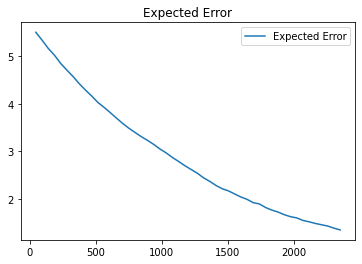

In [7]:
mean_error = np.mean(error_matrix, axis=0)
diagram_cut = 50

theorem_7_log = []
Ns = []
for i in range(num_of_logs):
    cut = int(n / num_of_logs)
    theorem_7_log.append(theorem_7(cut * (i+1), sigma, d))
    Ns.append(cut * (i+1))
    
p1, = plt.plot(Ns[:diagram_cut], mean_error[:diagram_cut], label='Expected Error')
plt.legend(loc='best')
plt.title('Expected Error')
plt.show()

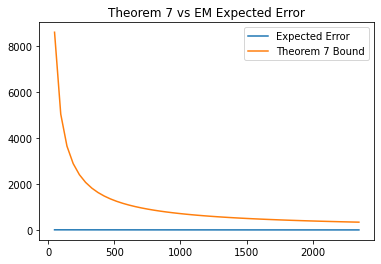

In [8]:
p1, = plt.plot(Ns[:diagram_cut], mean_error[:diagram_cut], label='Expected Error')
p1, = plt.plot(Ns[:diagram_cut], theorem_7_log[:diagram_cut], label='Theorem 7 Bound')
plt.legend(loc='best')
plt.title('Theorem 7 vs EM Expected Error')
plt.show()

[]

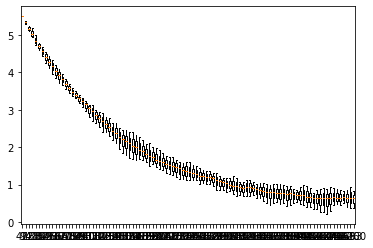

In [9]:
boxplot_dict = {}
diagram_cut = 100
for i in range(diagram_cut):
    boxplot_dict[cut * (i+1)] = [np.mean(error_matrix[:, i]), np.min(error_matrix[:, i]), np.max(error_matrix[:, i]), ]

fig, ax = plt.subplots()
ax.boxplot(boxplot_dict.values())
ax.set_xticklabels(boxplot_dict.keys())
plt.plot()

Based on the tren of the graph, the error seems to converge to zero in the limit. 